In [4]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from torch.utils.data import DataLoader 
from torchvision import datasets, transforms

import matplotlib.pyplot as plt 

In [145]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.CNN1 = nn.Conv2d(1, 16, 3, 1) # (in_channel, out_channel, kernel_size, stride)
        self.CNN2 = nn.Conv2d(16, 32, 3, 1)
        self.dropout1 = nn.Dropout2d(0.1)
        self.dropout2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64) # 12 * 12 * 32 
        self.fc2 = nn.Linear(64, 10)
        self.log_softmax = nn.LogSoftmax(dim=-1) # criterion으로 nll_loss 사용하지 않고, BCELoss를 사용하는 경우 log_softmax를 사용하지 않습니다. 
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.CNN1(x)
        x = self.relu(x)
        x = self.CNN2(x)
        x = self.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        outputs = self.log_softmax(x)
        return outputs 

In [151]:
def train(model, device, data_loader, optim, criterion, epoch):
    model.train()
    for i, (x, y) in enumerate(data_loader):
        x, y = x.to(device), y.to(device)
        optim.zero_grad()
        pred_y = model(x)
        loss = criterion(pred_y, y) 
        loss.backward()
        optim.step()
        
        if i % 10 == 0 :
            print(f'epoch: {epoch}\t {i}/{len(data_loader)} training loss: {loss.item():.6f}')

def test(model, device, dataloader, criterion):
    model.eval()
    loss, correct = 0, 0 
    with torch.no_grad():
        for (x, y) in dataloader:
            x, y = x.to(device), y.to(device)
            pred_y = model(x)
            
            loss += criterion(pred_y, y)
            
            pred = pred_y.argmax(dim=1, keepdim = True)
            
            correct += pred.eq(y.view_as(pred)).sum().item() # view_as 함수는 form을 맞춰줄때 사용합니다. 
    
    loss /= len(dataloader.dataset)
    print(f'\nTest dataset: Overall Loss {loss:.4f}, Overall Accuracy: {100. * correct / len(dataloader.dataset):.2f}%')

In [152]:
trainset =  datasets.MNIST('../data', train=True, download=True, 
                            transform = transforms.Compose([transforms.ToTensor(),
                                                            transforms.Normalize((0.1302, ), (0.3069, ))]))

testset =  datasets.MNIST('../data', train=False,
                            transform = transforms.Compose([transforms.ToTensor(),
                                                            transforms.Normalize((0.1302, ), (0.3069, ))]))

In [153]:
train_dataloader = DataLoader(trainset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=500, shuffle=True)

In [154]:
torch.manual_seed(0)
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu')

model = ConvNet()
optimizer = optim.Adadelta(model.parameters(), lr=0.5)
criterion = nn.NLLLoss()

In [155]:
for epoch in range(1, 3):
    train(model, device, train_dataloader, optimizer, criterion, epoch)
    test(model, device, test_dataloader, criterion)

epoch: 1	 0/1875 training loss: 2.301563
epoch: 1	 10/1875 training loss: 1.999758
epoch: 1	 20/1875 training loss: 1.404254
epoch: 1	 30/1875 training loss: 1.206638
epoch: 1	 40/1875 training loss: 0.798878
epoch: 1	 50/1875 training loss: 0.854382
epoch: 1	 60/1875 training loss: 0.916494
epoch: 1	 70/1875 training loss: 0.722387
epoch: 1	 80/1875 training loss: 1.117116
epoch: 1	 90/1875 training loss: 0.958758
epoch: 1	 100/1875 training loss: 0.912771
epoch: 1	 110/1875 training loss: 0.748333
epoch: 1	 120/1875 training loss: 0.910245
epoch: 1	 130/1875 training loss: 0.555541
epoch: 1	 140/1875 training loss: 0.889906
epoch: 1	 150/1875 training loss: 0.994307
epoch: 1	 160/1875 training loss: 0.876377
epoch: 1	 170/1875 training loss: 0.860758
epoch: 1	 180/1875 training loss: 0.770217
epoch: 1	 190/1875 training loss: 0.518235
epoch: 1	 200/1875 training loss: 0.948469
epoch: 1	 210/1875 training loss: 0.471645
epoch: 1	 220/1875 training loss: 0.887531
epoch: 1	 230/1875 tra

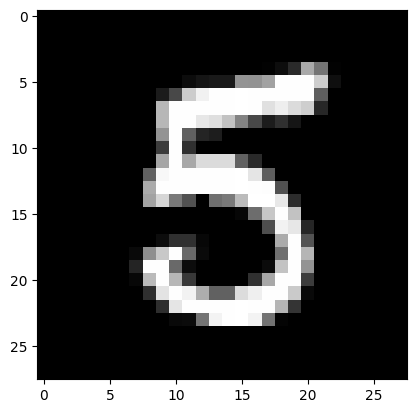

In [159]:
(sample_data, sample_target) = next(iter(test_dataloader))

plt.imshow(sample_data[0][0], cmap='gray', interpolation='none');

In [167]:
print(f'Model Prediction is : {model(sample_data).data.max(1)[1][0]}')
print(f'Ground Truth is : {sample_target[0]}')

Model Prediction is : 5
Ground Truth is : 5


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
